# Initializing an InfluxDB Client

Setting up basic parameter for influxDB client. 

In [30]:
from influxdb_client import InfluxDBClient
import warnings

# Initialize the InfluxDB client
token = "fP-GBq8Z1wZE7iW8qFBuxVy-ArVP9TqVec0naJ77XLECiwSr82aRXqvo3ylXZqU_2ad2vxWGcMoMbl3PXqAZ7A=="
server_url = "http://140.112.12.62:8086"
client = InfluxDBClient(url=server_url, token=token)
org = "NTUCE"
query_api = client.query_api()

# Disable influxdb pivot warning
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.simplefilter("ignore", MissingPivotFunction)

## Query data from Parsivel2
Parsivel2 gets new data every **10** seconds.  
Data could be large when you query it over a long period of time.  
  
You can choose either way listed below to save time:
* Preprocess data on server using flux.
* Query raw bytes data rather turning them into FluxTable.  
* Using asynchronous Influxdb API.
* Turning raw data into csv or pandas tables rather than FluxTable.

### Query precipitation intensity and bucket depth from two Pluvio gauge.
Pluvio_L and Pluvio_S are both weighing rain gauge with different size.  
The calculate intensity from bucket weight.  
Here we query non-realtime bucket and intensity to see the relationship between these two.

(0.0, 32.0)

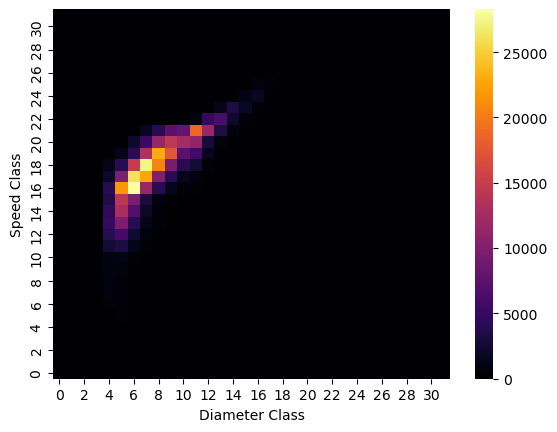

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## We query data using ordinary query function.
## This function return a TableList object, which is a list of Table objects.
with open("flux/parsivel_sum_dsd.flux", "r") as fluxfile:
    query_str = fluxfile.read()
    tables = query_api.query(org="NTUCE", query = query_str)

drops = np.zeros((32, 32), dtype=np.int32)

## Each Table object contains a list of FluxRecord objects.
## But there's only one record in each table, so we can just use table.records[0] to get the summed record.
for table in tables:
    ## To know the dict keys of the record, we can use table.get_group_key()
    ## print(table.get_group_key()[0])
    size = int(table.records[0]['Diameter Class'])
    speed = int(table.records[0]['Speed Class'])
    drops[speed, size] = table.records[0].get_value()
    
plt.clf()
sns.heatmap(drops, cmap="inferno")
plt.xlabel("Diameter Class")
plt.ylabel("Speed Class")
plt.xlim(0, 32)
plt.ylim(0, 32)

### Query general weather parameters from Parsivel2.
Parsivel have multiple weather parameters including rain intensity, radar reflectivity, mor visibility etc.  
Here we query intensity and MOR visibility with proformance optimized flux file.  

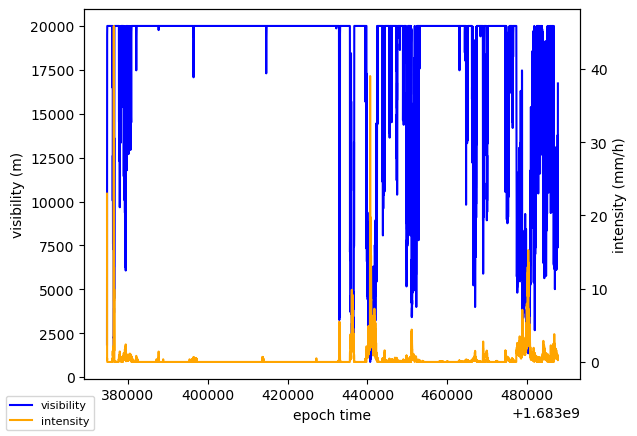

In [66]:
# Get visibility data
with open("flux/parsivel_MOR_visibility.flux") as fluxfile:
    visibility_query_str = fluxfile.read()
    visibility = query_api.query_data_frame(org="NTUCE", query = visibility_query_str)
    # Drop useless columns
    visibility.drop(columns=["result", "table"], inplace=True)
    # Reindex the dataframe with time column
    visibility.set_index("_time", inplace=True)
    # Fill missing timestamp with default visibility value 20000
    visibility = visibility.reindex(list(range(visibility.index.min(), visibility.index.max(), 10)), fill_value=20000)

# Get intensity data
with open("flux/parsivel_intensity.flux") as fluxfile:
    intensity_query_str = fluxfile.read()
    intensity = query_api.query_data_frame(org="NTUCE", query = intensity_query_str)
    # Drop useless columns
    intensity.drop(columns=["result", "table"], inplace=True)
    # Reindex the dataframe with time column
    intensity.set_index("_time", inplace=True)
    # Fill missing timestamp with default intensity value 0
    intensity = intensity.reindex(list(range(intensity.index.min(), intensity.index.max(), 10)), fill_value=0)

fig, ax1 = plt.subplots()
plt.rcParams['legend.fontsize'] = 8

# Plot visibility
ax1.plot(visibility.index, visibility["_value"], color="blue", label="visibility")
ax1.set_xlabel("epoch time")
ax1.set_ylabel("visibility (m)")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot intensity
ax2.plot(intensity.index, intensity["_value"], color="orange", label="intensity")
ax2.set_ylabel("intensity (mm/h)")

fig.legend(loc="lower left")
plt.show()

### Query machine status data from Parsivel2.
The status of the sensor could influence the precipitation output.  
For example, the amplitude of the laser strip could be influenced by dirty glass and temperature.  
Here we query temperature from 4 different sensor on Parsivel_2 and see how tempearture influence the ampliutude of laser strip.


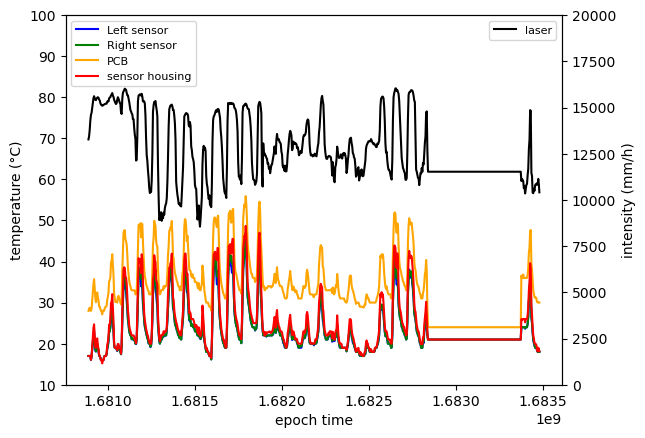

In [65]:
with open("flux/parsivel_temp.flux") as fluxfile:
    temp_query_str = fluxfile.read()
    temp = query_api.query_data_frame(org="NTUCE", query = temp_query_str)
    # Drop useless columns
    temp.drop(columns=["result", "table"], inplace=True)
    # Reindex the dataframe with time column
    temp.set_index("_time", inplace=True)

with open("flux/parsivel_laser_amplitude.flux") as fluxfile:
    laser_query_str = fluxfile.read()
    laser = query_api.query_data_frame(org="NTUCE", query = laser_query_str)
    # Drop useless columns
    laser.drop(columns=["result", "table"], inplace=True)
    # Reindex the dataframe with time column
    laser.set_index("_time", inplace=True)


fig, ax1 = plt.subplots()
plt.rcParams['legend.fontsize'] = 8

# Plot visibility
ax1.plot(temp.index, temp["Left sensor head temperature"], color="blue", label="Left sensor")
ax1.plot(temp.index, temp["Right sensor head temperature"], color="green", label="Right sensor")
ax1.plot(temp.index, temp["Temperature PCB"], color="orange", label="PCB")
ax1.plot(temp.index, temp["Temperature in the sensor housing"], color="red", label="sensor housing")
ax1.set_ylim(10, 100)
ax1.set_xlabel("epoch time")
ax1.set_ylabel("temperature (°C)")
ax1.legend(loc="upper left")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot intensity
ax2.plot(laser.index, laser["_value"], color="black", label="laser")
ax2.set_ylim(0, 20000)
ax2.set_ylabel("intensity (mm/h)")
ax2.legend(loc="upper right")

plt.show()